# HW №2 от Бондаренко Алексея (bondaleksey@gmail.com)

Цель данного ноутбука на тестовом наборе данных провести:
- сравнение методов кластеризации k-means, hierarhical и DBSCAN
- осуществить визуализацию разбиения на кластеры, основывась на методы сжатия признакового пространства PCA, tSNE, UMAP 


Основные пункты задания: 

*   Разведовательный анализ (EDA) и предобработка данных
*   Кластеризация и визуалиазция разбиений 
*   Интерпретация результатов

Мотивация: 
Сегментация клиентов (в данном случае - банка). Крайне полезная операция, которая позволяет вам лучше познакомится со своей аудиторией, понять, на какие группы она делится и чем они характеризуются.

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# plt.style.use(['seaborn-darkgrid'])
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA

# 1 Разведовательный анализ и предобработка данных

В работе используются известный датасет [клиентов немецкого банка](https://www.kaggle.com/uciml/german-credit) размещенный на Kaggle. Чтобы не плодить лишние сущности папка data включена в файл gitignore. 




In [30]:
# from os.path import exists
# filepath = 'data_cl/'
# if exists(filepath):
#     print(f"filepath {filepath} existing")
    

## 1.1 Получим первое впечатление о данных 

In [31]:
data = pd.read_csv('data_cl/archive.zip', compression='zip', header=0, sep=',', quotechar='"',index_col=0)

In [32]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB


In [34]:
data_short = data.dropna()
data_short.info()   

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522 entries, 1 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               522 non-null    int64 
 1   Sex               522 non-null    object
 2   Job               522 non-null    int64 
 3   Housing           522 non-null    object
 4   Saving accounts   522 non-null    object
 5   Checking account  522 non-null    object
 6   Credit amount     522 non-null    int64 
 7   Duration          522 non-null    int64 
 8   Purpose           522 non-null    object
dtypes: int64(4), object(5)
memory usage: 40.8+ KB


In [35]:
data_full = data.fillna('na')
data_full.info()            

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB


In [36]:
data_short.describe()

,Age,Job,Credit amount,Duration
count,522.000000,522.000000,522.000000,522.000000
mean,34.888889,1.875479,3278.745211,21.339080
std,11.787918,0.682811,2929.155177,12.474079
min,19.000000,0.000000,276.000000,6.000000
25%,26.000000,2.000000,1297.500000,12.000000
50%,31.500000,2.000000,2326.500000,18.000000
75%,41.000000,2.000000,3971.250000,26.750000
max,75.000000,3.000000,18424.000000,72.000000


In [37]:
data_full.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


## 1.2 Проведем разведовательный анализ данных

In [38]:
def EDA(data):
    cols = data_full.columns
    print('Printing figures for columns:\n',cols)
    for item in cols:
        dt = data[item].dtype  
        print(f'{item} type is {dt}')  
        if dt == 'int64'or dt == 'int32':        
            ax = data[item].plot(kind = 'hist', bins = 20)
            ax.set_xlabel(item)
            plt.show()
        elif dt == 'object':
            ax = data[item].value_counts().plot(kind = 'bar')
            ax.set_xlabel(item)
            plt.show()
        else:
            print(f'ooops, have problems with {item}')


Printing figures for columns:
 Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose'],
      dtype='object')
Age type is int64


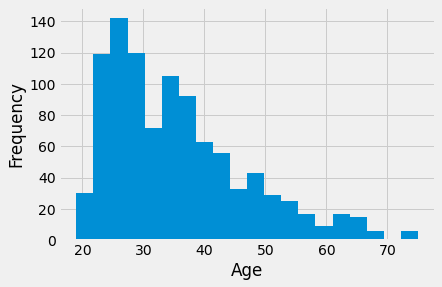

Sex type is object


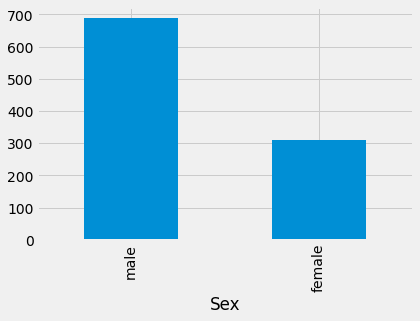

Job type is int64


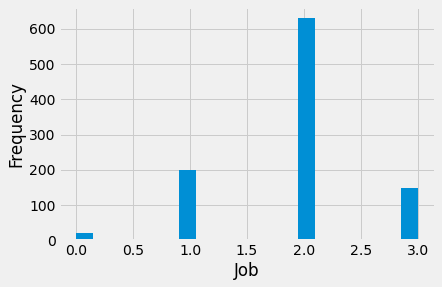

Housing type is object


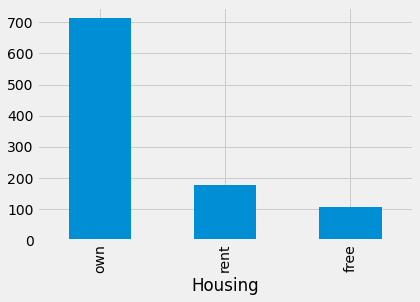

Saving accounts type is object


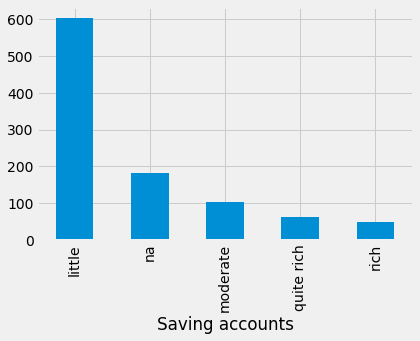

Checking account type is object


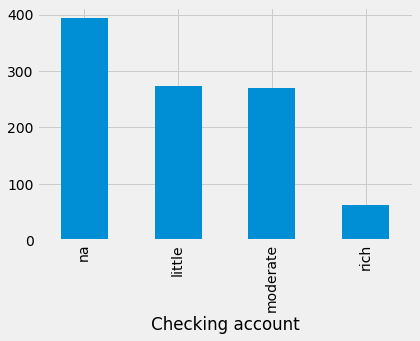

Credit amount type is int64


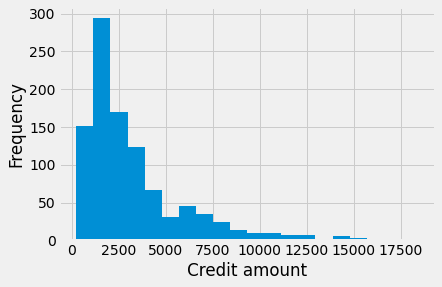

Duration type is int64


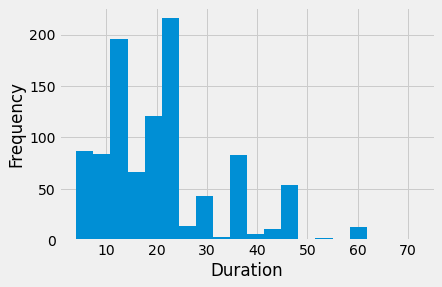

Purpose type is object


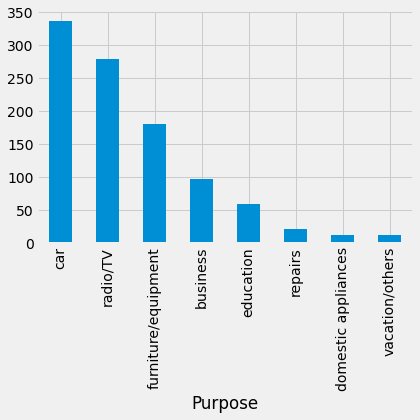

In [39]:
EDA(data_full)


## 1.3 Преобразуем все признаки в числовые

In [40]:
def preproseccing(data):
    categorical_cols = [x for x in data.columns if data[x].dtype == 'object']    
    dummies = pd.get_dummies(data[categorical_cols], drop_first=True)
    df = pd.concat([data.drop(categorical_cols,axis=1), dummies],axis=1)    
    return df

In [41]:
data_full_floats = preproseccing(data_full)
data_full_floats.head()

,Age,Job,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_na,Saving accounts_quite rich,...,Checking account_moderate,Checking account_na,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,2,1169,6,1,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,22,2,5951,48,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,49,1,2096,12,1,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,45,2,7882,42,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,53,2,4870,24,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [42]:
data_short_floats = preproseccing(data_short)
data_short_floats.head()

,Age,Job,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
1,22,2,5951,48,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
3,45,2,7882,42,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,53,2,4870,24,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,35,3,6948,36,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0
9,28,3,5234,30,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0


## 1.4 Приведем все даные к одному масштабу

При нахождении расстояния предполагается, что каждый признак имеет "одинаковый вес" = расстояния по разным признакам вносят одинаковый вклад в общее расстояние. А так как единицы измерения физического значения признака измеряются в разных диапазонах, то и веса этих признаком будут разные. Поэтому StandardScaler() необходимая операция при кластеризации.

In [43]:
scaler = StandardScaler()
X_full = scaler.fit_transform(data_full_floats)
X_short = scaler.fit_transform(data_short_floats)

In [44]:
print(type(X_full))
print('X_full: ',X_full.shape)
print(X_full[:6,:6])
print('X_short: ',X_short.shape)
print(X_short[:6,:6])

<class 'numpy.ndarray'>
X_full:  (1000, 21)
[[ 2.76645648  0.14694918 -0.74513141 -1.23647786  0.67028006  0.63444822]
 [-1.19140394  0.14694918  0.94981679  2.24819436 -1.49191369  0.63444822]
 [ 1.18331231 -1.38377145 -0.41656241 -0.73866754  0.67028006  0.63444822]
 [ 0.8315025   0.14694918  1.63424694  1.75038404  0.67028006 -1.57617276]
 [ 1.53512213  0.14694918  0.5666635   0.25695309  0.67028006 -1.57617276]
 [-0.04802204 -1.38377145  2.05000901  1.25257373  0.67028006 -1.57617276]]
X_short:  (522, 19)
[[-1.09444711  0.18254035  0.9131705   2.13935578 -1.4516001   0.70406108]
 [ 0.85857489  0.18254035  1.57303731  1.65789696  0.68889496 -1.42033131]
 [ 1.53788689  0.18254035  0.54376811  0.21352053  0.68889496 -1.42033131]
 [ 0.00943489  1.64847973  1.25386818  1.17643815  0.68889496 -1.42033131]
 [-0.58496311  1.64847973  0.66815522  0.69497934  0.68889496  0.70406108]
 [-0.83970511  0.18254035 -0.67789105 -0.7493971  -1.4516001  -1.42033131]]


# 2 Моделирование
Рассмотрим 3 варианта кластеризации: K-means, hierarhical и DBSCAN.
Определять оптимальное число кластеров, будем методом локтя (Elbow) и методом силуэта (Silhouette)

## 2.1 Kmeans


In [45]:
def calculate_elbow_kmean(data):
    output_inertia = []
    output_range = list(range(1,25))
    for k in output_range:
        # print(k)
        kmeans = KMeans(n_clusters=k, init='k-means++')
        kmeans = kmeans.fit(data)        
        output_inertia.append(kmeans.inertia_)
    return {'range':output_range, 'inertia':output_inertia}

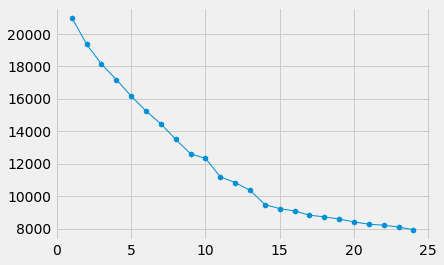

In [46]:
elbow_full = calculate_elbow_kmean(X_full)
plt.plot(elbow_full['range'],elbow_full['inertia'],marker='h',linewidth=1, markersize=5);
plt.xlabel('Число кластеров')
plt.ylabel('Мера инерции')
plt.title('Правило локтя для всего набора данных')
plt.show()

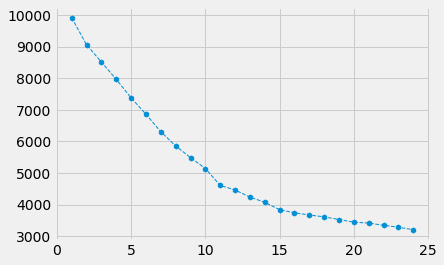

In [47]:
elbow_short = calculate_elbow_kmean(X_short)
plt.plot(elbow_short['range'],elbow_short['inertia'],marker='h',linestyle='dashed',linewidth=1, markersize=5);
plt.xlabel('Число кластеров')
plt.ylabel('Мера инерции')
plt.title('Правило локтя для укороченного набора данных')
plt.show()

In [48]:
print(max(data.shape))

1000


In [49]:
def silhouette(data):
    output_silhouette = []
    output_range = list(range(2,50))
    for k in output_range:
        labels = KMeans(n_clusters=k, init='k-means++', random_state=200).fit(data).labels_
        silhouette = metrics.silhouette_score(data, labels, metric='euclidean', sample_size=max(data.shape),random_state=200)
        output_silhouette.append(silhouette)
        # print(f"Silhouette score for k(clusters) = {k} is {silhouette}")
    return {'range':output_range, 'silhouette':output_silhouette}
        

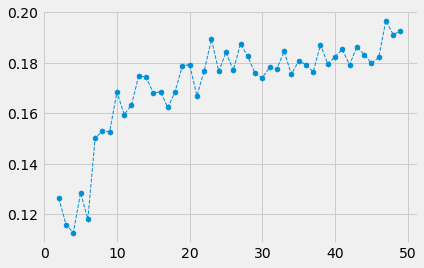

In [50]:
silh_full = silhouette(X_full)
plt.plot(silh_full['range'],silh_full['silhouette'],marker='h',linestyle='dashed',linewidth=1, markersize=5);
plt.xlabel('Число кластеров')
plt.ylabel('Силуэт')
plt.title('Величина силуэта для всего набора данных')
plt.show()

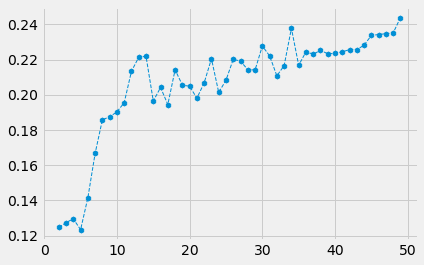

In [51]:
silh_short = silhouette(X_short)
plt.plot(silh_short['range'],silh_short['silhouette'],marker='h',linestyle='dashed',linewidth=1, markersize=5);
plt.xlabel('Число кластеров')
plt.ylabel('Силуэт')
plt.title('Величина силуэта для укороченного набора данных')
plt.show()

## 2.2 Hierarhical

In [52]:
# Was taken from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
#
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [60]:
X_full.shape

(1000, 21)

In [148]:
def plot_dendrograms(data):
    linkage=["ward" , "average", "complete", "single"]
    for link in linkage:
        model = AgglomerativeClustering(linkage=link, distance_threshold = 0, n_clusters=None)
        model.fit(data)
        plt.title(f"Дендограмма, linkage:{link}")
        plot_dendrogram(model, truncate_mode="level", p=4)
        plt.xlabel("Number of points in node.")
        plt.show()

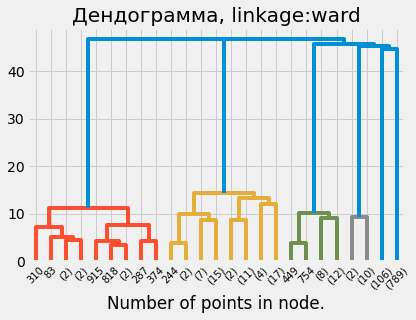

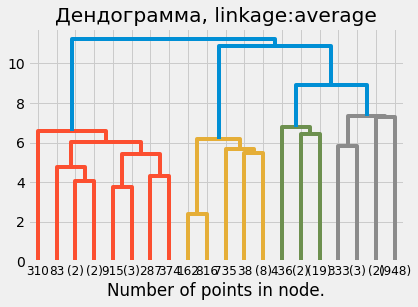

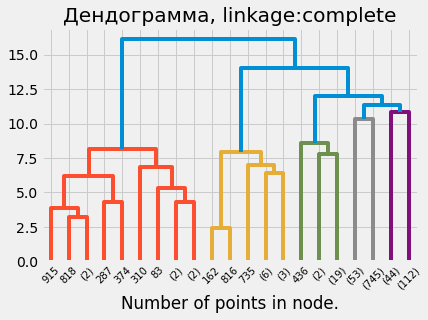

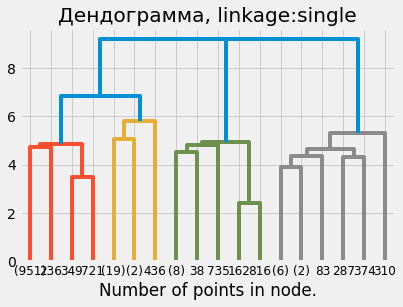

In [149]:
plot_dendrograms(X_full)

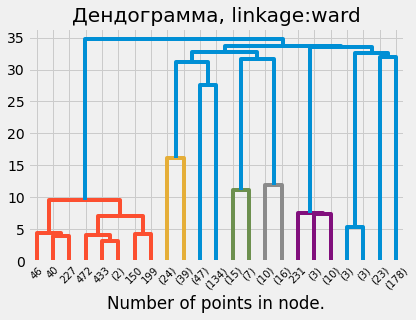

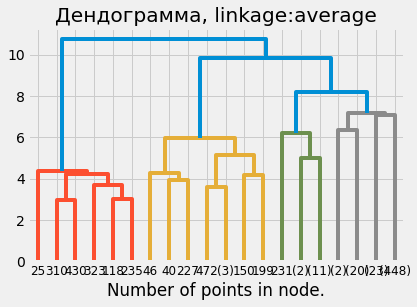

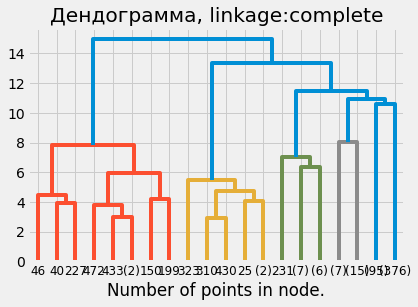

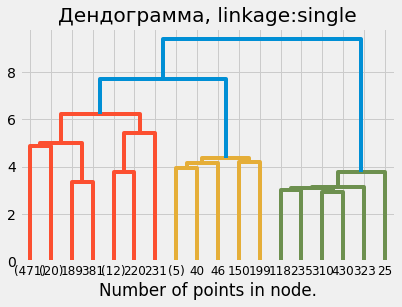

In [150]:
plot_dendrograms(X_short)

In [266]:
def use_hierarchical(data,link):
    eps_range = np.concatenate((np.linspace(1,15,100), np.linspace(15.1,50,50)))
    output = []
    for epsilon in eps_range:       
        labels = AgglomerativeClustering(linkage=link, distance_threshold = epsilon, n_clusters=None).fit_predict(data)
        n_clusters = len(set(labels))
        if n_clusters<2:
            continue
        result = {
            "epsilon":epsilon,
            "clusters":n_clusters,                        
            "Silhouette": metrics.silhouette_score(data, labels)           
        }
        # print(result)
        output.append(result)
    return output

In [272]:
def plot_df(data,name=""):
    cols = data.columns
    # print('Printing figures for columns:\n',cols)
    for item in cols:        
        ax = data[item].plot(kind = 'line')
        ax.set_title(name)
        ax.set_xlabel(item)
        plt.show()   

In [271]:
def full_hierarchical_search(data):
    linkage=["ward" , "average", "complete", "single"]
    for link in linkage:
        h_data = use_hierarchical(data,link)
        df_data = pd.DataFrame(h_data)
        df_data = df_data.set_index("epsilon")
        print("____________ Plot for {link} ____________")    
        plot_df(df_data,f"Hierarchical search with linkage: {link}")
        plot_df(df_data.iloc[-30:],f"Hierarchical search with linkage: {link}")
    

Printing figures for columns:
 Index(['clusters', 'Silhouette'], dtype='object')


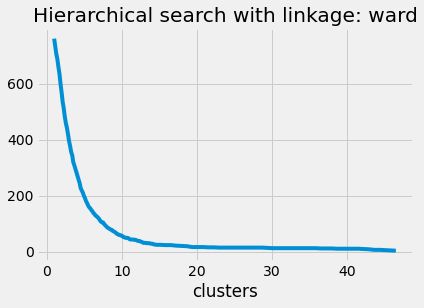

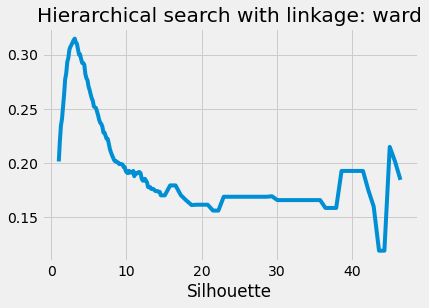

Printing figures for columns:
 Index(['clusters', 'Silhouette'], dtype='object')


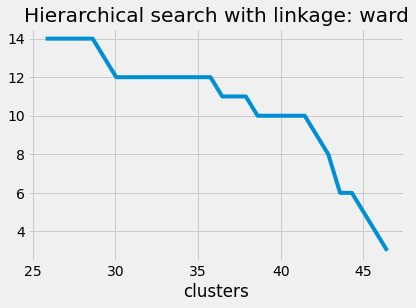

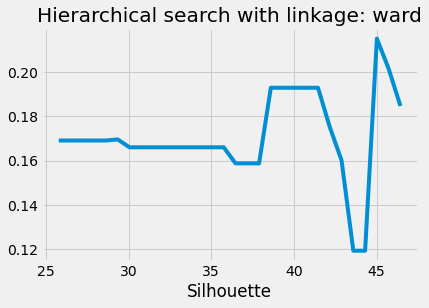

Printing figures for columns:
 Index(['clusters', 'Silhouette'], dtype='object')


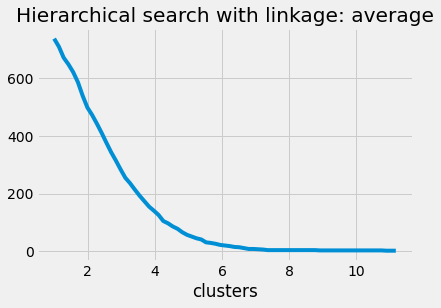

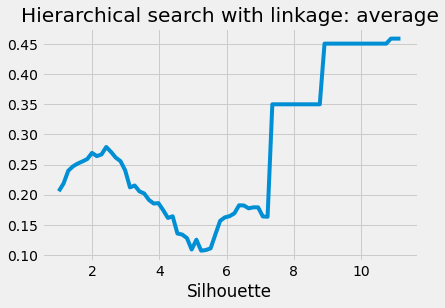

Printing figures for columns:
 Index(['clusters', 'Silhouette'], dtype='object')


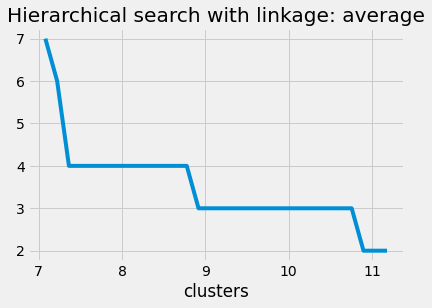

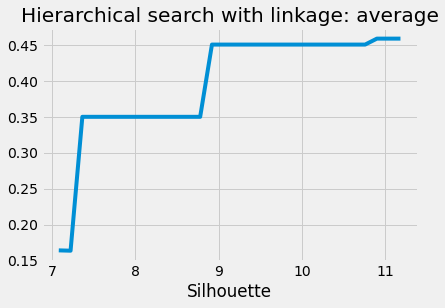

Printing figures for columns:
 Index(['clusters', 'Silhouette'], dtype='object')


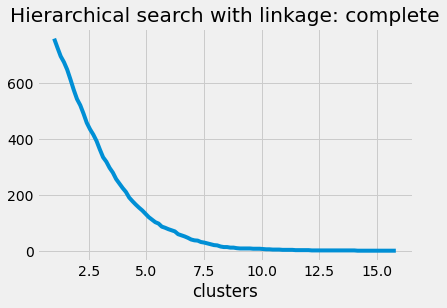

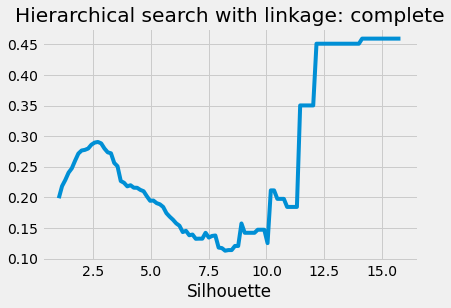

Printing figures for columns:
 Index(['clusters', 'Silhouette'], dtype='object')


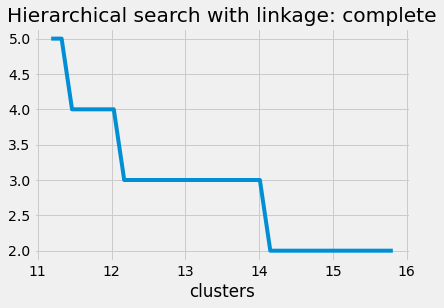

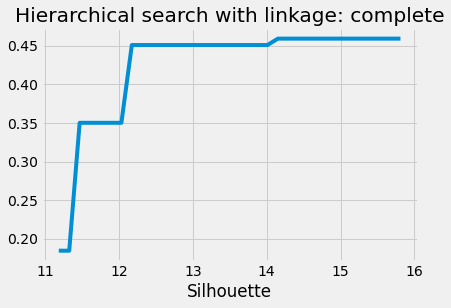

Printing figures for columns:
 Index(['clusters', 'Silhouette'], dtype='object')


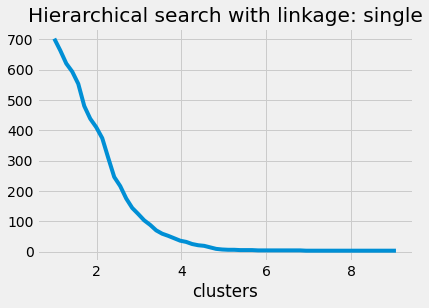

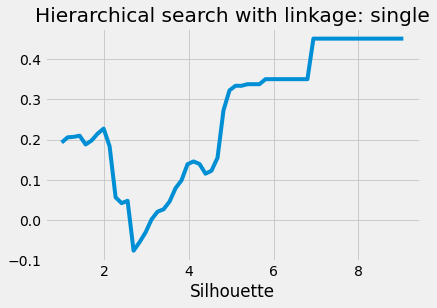

Printing figures for columns:
 Index(['clusters', 'Silhouette'], dtype='object')


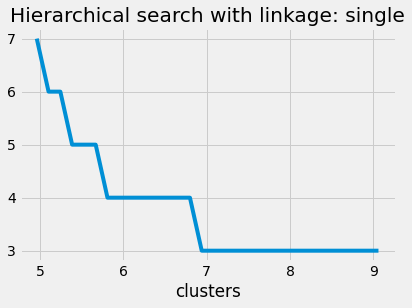

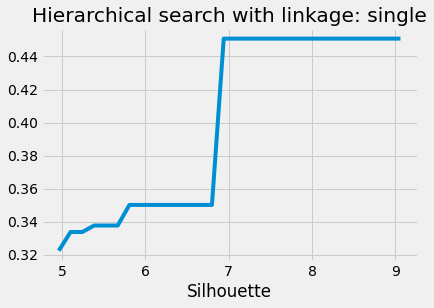

In [269]:
full_hierarchical_search(X_full)

Printing figures for columns:
 Index(['clusters', 'Silhouette'], dtype='object')


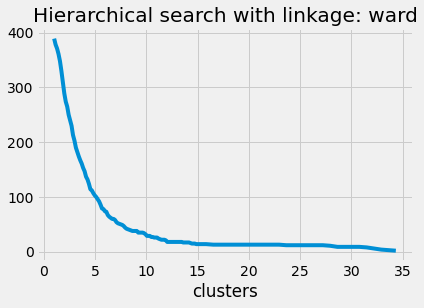

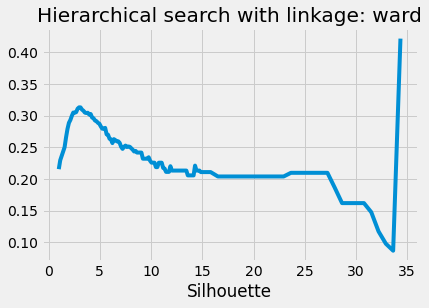

Printing figures for columns:
 Index(['clusters', 'Silhouette'], dtype='object')


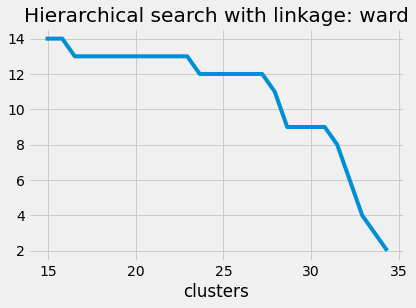

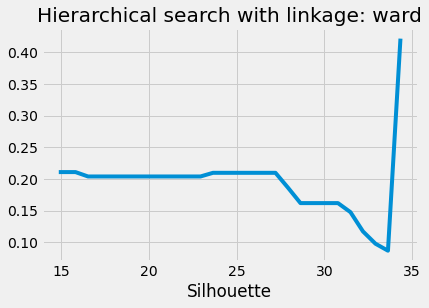

Printing figures for columns:
 Index(['clusters', 'Silhouette'], dtype='object')


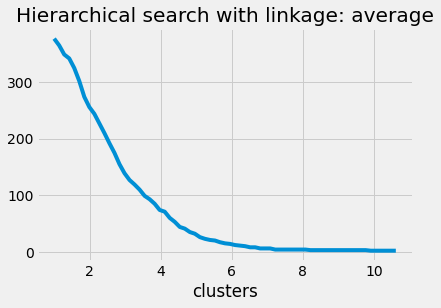

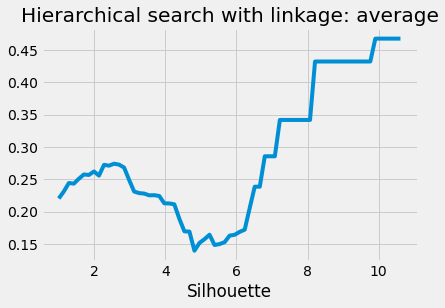

Printing figures for columns:
 Index(['clusters', 'Silhouette'], dtype='object')


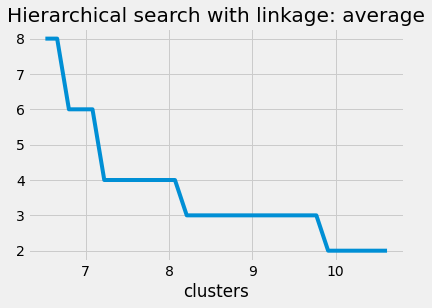

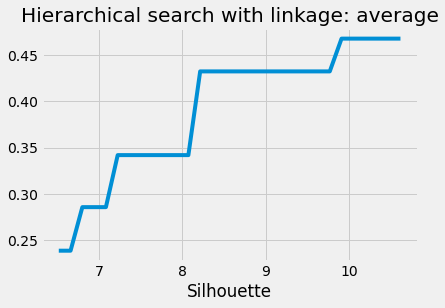

Printing figures for columns:
 Index(['clusters', 'Silhouette'], dtype='object')


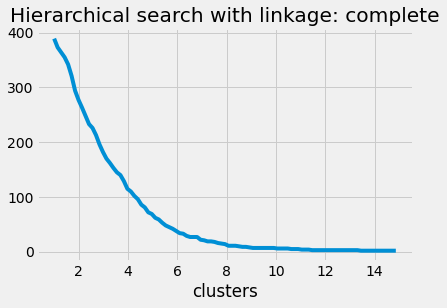

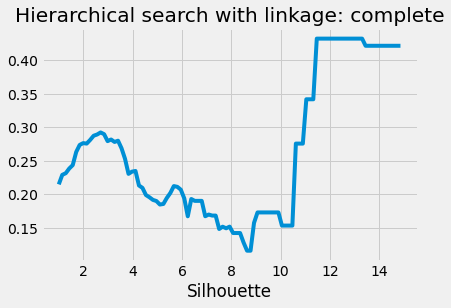

Printing figures for columns:
 Index(['clusters', 'Silhouette'], dtype='object')


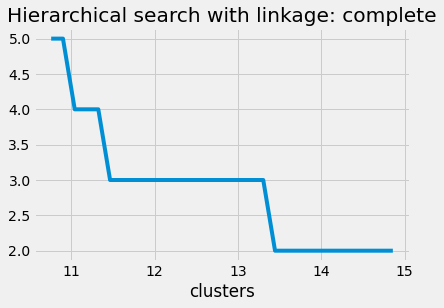

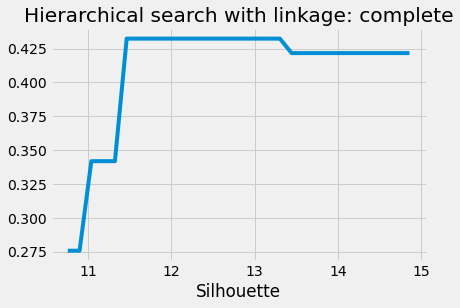

Printing figures for columns:
 Index(['clusters', 'Silhouette'], dtype='object')


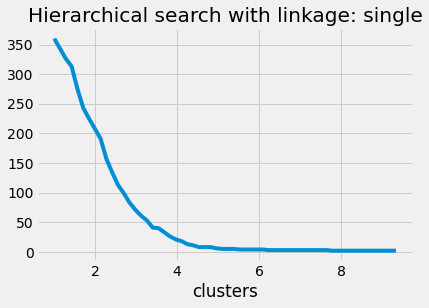

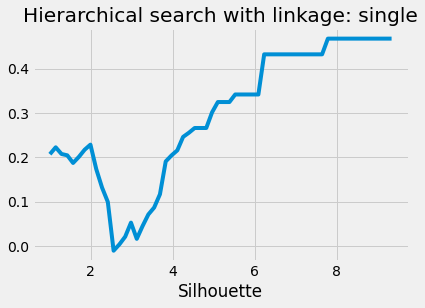

Printing figures for columns:
 Index(['clusters', 'Silhouette'], dtype='object')


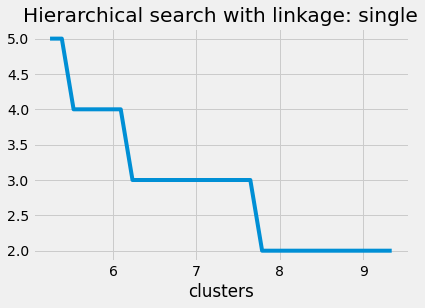

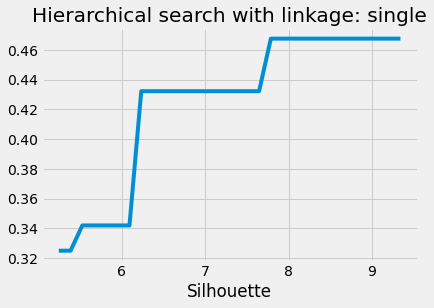

In [270]:
full_hierarchical_search(X_short)

# 2.3 DBSCAN

In [273]:
def use_dbscan(data):
    eps_range = np.linspace(0.1,10,100)
    output = []
    for epsilon in eps_range:
        db = DBSCAN(eps=epsilon, min_samples=7).fit(data)        
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
        # print(labels)

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        if n_clusters_<2:
            continue
        result = {
            "epsilon":epsilon,
            "clusters":n_clusters_,
            "noise_points": n_noise_,            
            "Silhouette": metrics.silhouette_score(data, labels)           
        }
        # print(result)
        output.append(result)
    return output

In [274]:
dbscan_full = use_dbscan(X_full)
df_dbscan_full = pd.DataFrame(dbscan_full)
df_dbscan_full = df_dbscan_full.set_index("epsilon")
print(df_dbscan_full.tail())

         clusters  noise_points  Silhouette
epsilon                                    
8.7             3             0    0.450806
8.8             3             0    0.450806
8.9             3             0    0.450806
9.0             3             0    0.450806
9.1             3             0    0.450806


In [275]:
dbscan_short = use_dbscan(X_short)
df_dbscan_short = pd.DataFrame(dbscan_short)
df_dbscan_short = df_dbscan_short.set_index("epsilon")
print(df_dbscan_short.tail())

         clusters  noise_points  Silhouette
epsilon                                    
7.2             2             6    0.432327
7.3             2             6    0.432327
7.4             2             6    0.432327
7.5             2             6    0.432327
7.6             2             6    0.432327


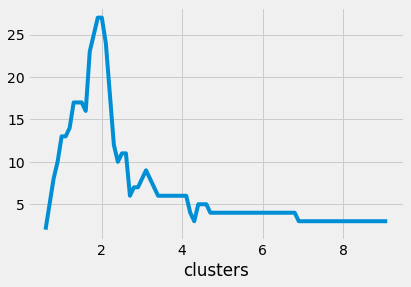

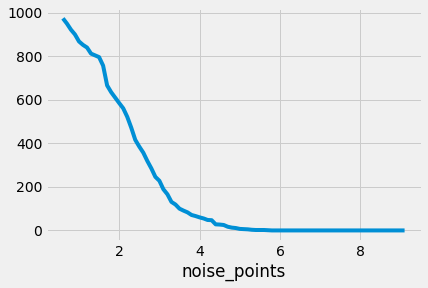

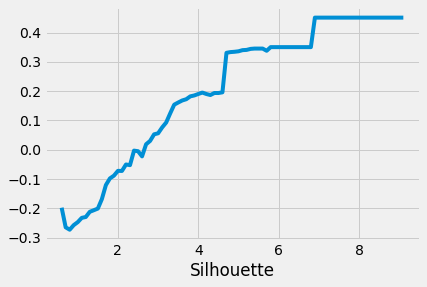

In [276]:
plot_df(df_dbscan_full)

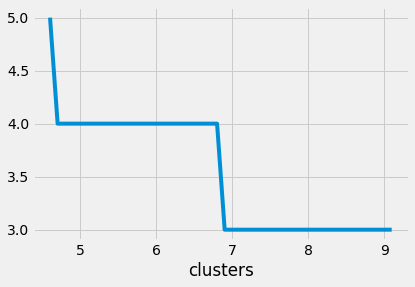

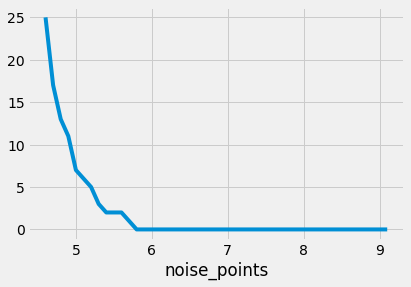

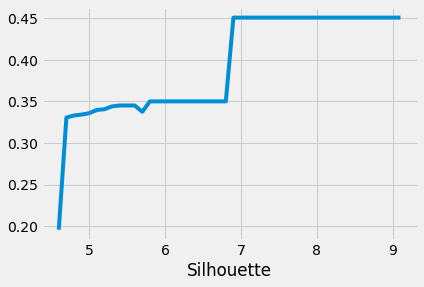

In [279]:
plot_df(df_dbscan_full.iloc[40:])

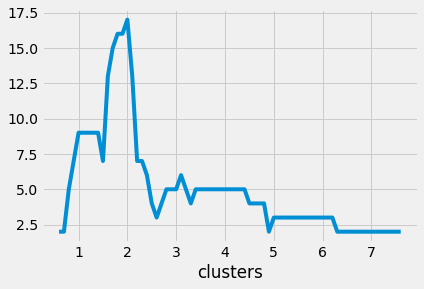

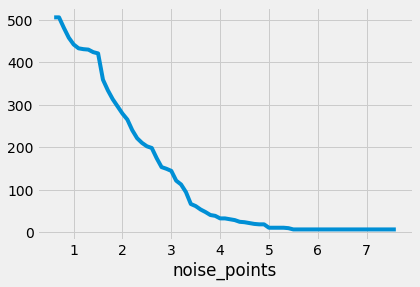

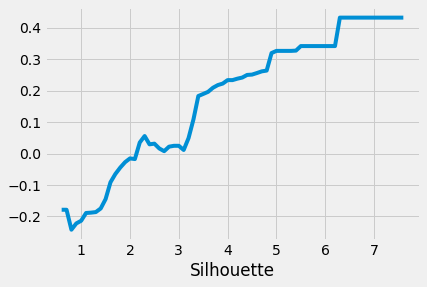

In [277]:
plot_df(df_dbscan_short)

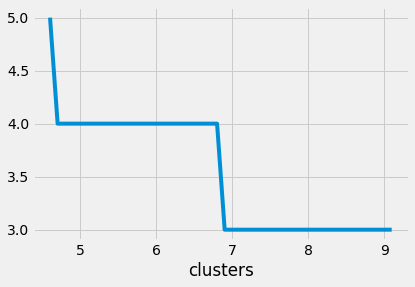

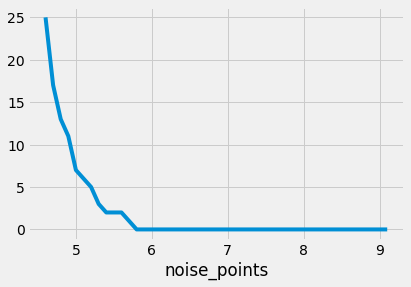

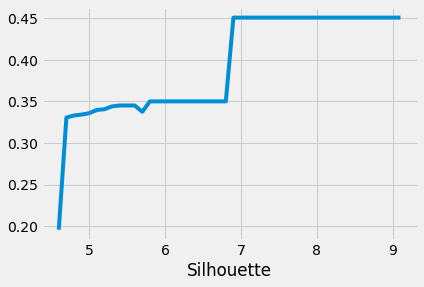

In [278]:
plot_df(df_dbscan_full.iloc[40:])

Printing figures for columns:
 Index(['clusters', 'noise_points', 'Silhouette'], dtype='object')


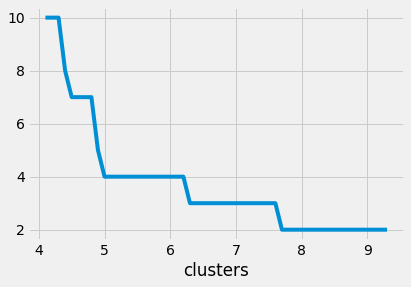

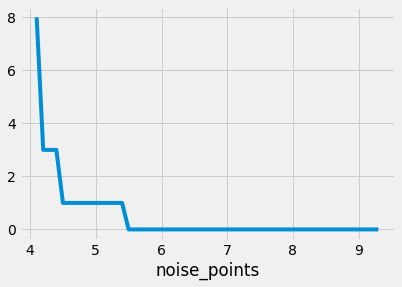

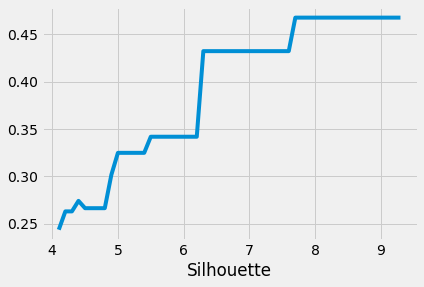

In [190]:
plot_df(df_dbscan_short.iloc[40:])

# 3 Визуализация кластеризации

In [151]:
print(X_full.shape[1])

21


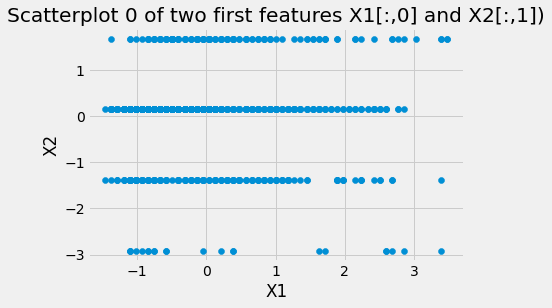

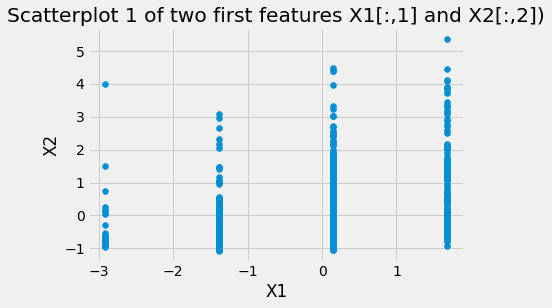

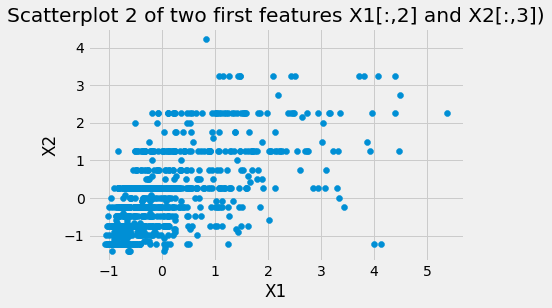

In [159]:
# plt.figure(figsize=(14, 6))

for i in range(min(3,(X_full.shape[1]-1))):
    plt.scatter(X_full[:,i], X_full[:,i+1]) #,c=y, s=20, cmap='coolwarm')
    plt.title(f'Scatterplot {i} of two first features X1[:,{i}] and X2[:,{i+1}])')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

In [280]:
def plot_pca_with_labels(data,labels,name):
    pca = PCA(n_components=2)
    pca.fit(data)
    X_pca = pca.transform(data)    
    plt.scatter(X_pca[:,0], X_pca[:,1],c=labels, s=20)#, cmap='coolwarm')
    plt.title(f'PCA with {len(set(labels))} clusters from {name}')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

In [292]:
def plot_pca(data, threshold=7, clusters=2):
    # threshold = 7
    l_dbscan = DBSCAN(eps=threshold, min_samples=7).fit(data).labels_
    # l_hierarchy = AgglomerativeClustering(linkage="average", distance_threshold = threshold, n_clusters=clusters).fit_predict(data)
    l_hierarchy = AgglomerativeClustering(linkage="average", n_clusters=clusters).fit_predict(data)
    l_kmeans = KMeans(n_clusters=clusters, init='k-means++').fit(data).labels_        
    plot_pca_with_labels(data,l_kmeans, "KMeans")
    plot_pca_with_labels(data,l_hierarchy, "Hierarchy")
    plot_pca_with_labels(data,l_dbscan, "DBSCAN")
    

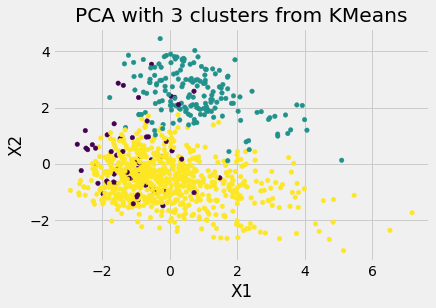

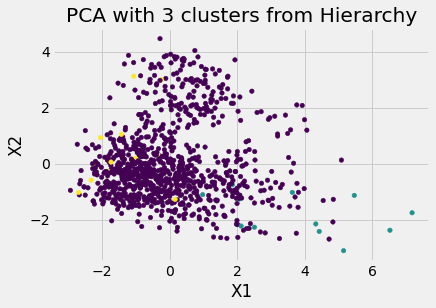

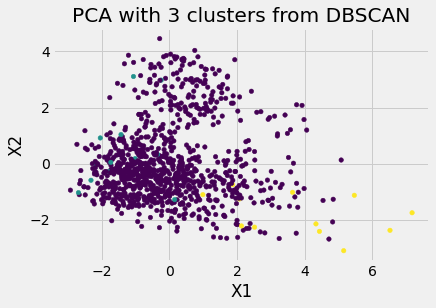

In [293]:
plot_pca(X_full, threshold=7, clusters=3)

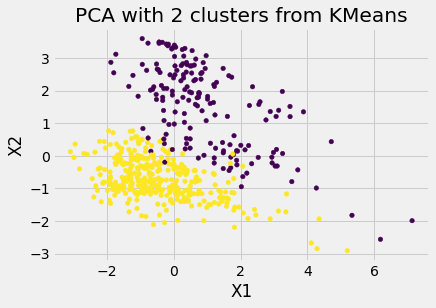

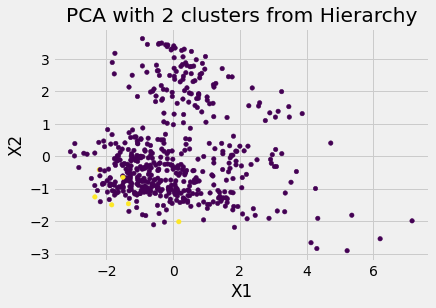

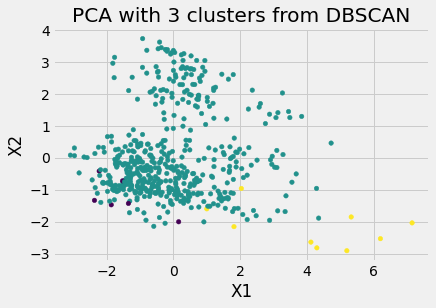

In [294]:
plot_pca(X_short, threshold=7, clusters=2)